2.0
Processing dataset size: 10
Processing dataset size: 100
Processing dataset size: 1000
Selection rates for each dataset size:
      1 components  2 components  3 components  4 components  5 components  \
10            0.99          0.01          0.00          0.00          0.00   
100           0.00          0.00          0.13          0.70          0.16   
1000          0.00          0.00          0.00          0.53          0.35   

      6 components  7 components  8 components  9 components  
10            0.00           0.0          0.00           0.0  
100           0.01           0.0          0.00           0.0  
1000          0.11           0.0          0.01           0.0  


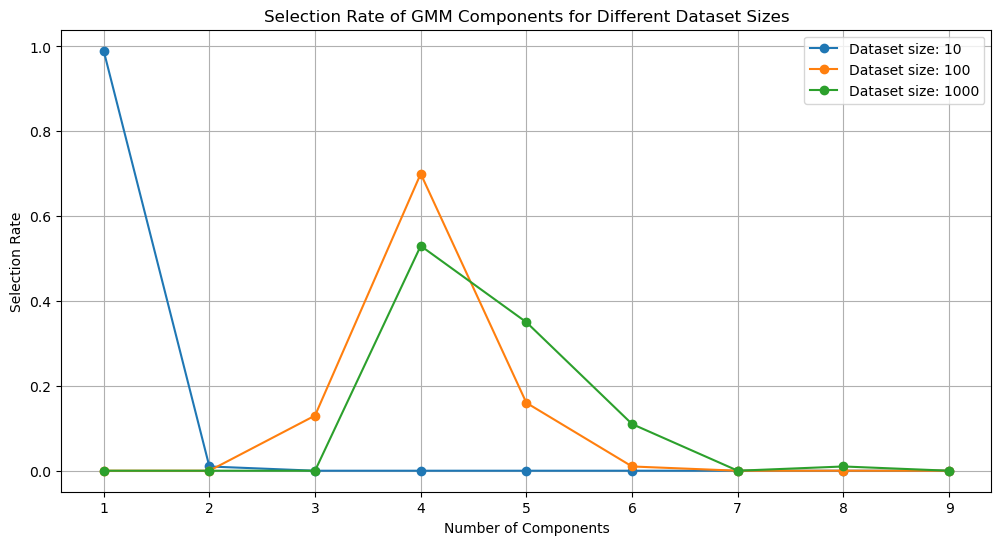

In [12]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import pandas as pd

# Set random seed for reproducibility
# np.random.seed(0)


# Define the true GMM parameters with overlapping components
# Step 1: Specify initial covariance matrices
covariances = [
    np.array([[1, 0.8], [0.8, 1]]),
    np.array([[1, -0.6], [-0.6, 1]]),
    np.array([[1, 0.5], [0.5, 1]]),
    np.array([[1, -0.7], [-0.7, 1]])
]

# Step 2: Calculate eigenvalues of each covariance matrix
eigenvalues = [np.linalg.eigvalsh(cov) for cov in covariances]
average_eigenvalues = [np.mean(eig) for eig in eigenvalues]

# Step 3: Define means with overlap
# For overlap, we set the distance between the means of two components (e.g., 0 and 1) to the sum of their average eigenvalues
overlap_distance = average_eigenvalues[0] + average_eigenvalues[1]
print(overlap_distance)
means = [
    np.array([0, 0]),  # Mean for component 0
    np.array([overlap_distance, overlap_distance]),  # Mean for component 1, placed at a distance for overlap
    np.array([6, 0]),  # Mean for component 2, further away
    np.array([3, -3])  # Mean for component 3, further away
]

# Step 4: Define weights for each component to ensure variation in data distribution
weights = [0.2, 0.3, 0.4, 0.1]

# Data generation function
def generate_data(n_samples):
    data = []
    labels = []
    for _ in range(n_samples):
        component = np.random.choice(len(true_means), p=true_weights)
        sample = np.random.multivariate_normal(true_means[component], true_covariances[component])
        data.append(sample)
        labels.append(component)
    return np.array(data), np.array(labels)

# Experiment parameters
dataset_sizes = [10, 100, 1000]
num_repeats = 100
num_folds = 10
max_components = 9

# Store selection rates for each dataset size
selection_rates = {size: np.zeros(max_components) for size in dataset_sizes}

# Main experiment loop
for size in dataset_sizes:
    print(f"Processing dataset size: {size}")
    for _ in range(num_repeats):
        data, _ = generate_data(size)

        best_order_counts = np.zeros(max_components)
        kf = KFold(n_splits=num_folds)

        for n_components in range(1, max_components + 1):
            fold_log_likelihoods = []
        
            for train_index, val_index in kf.split(data):
                X_train, X_val = data[train_index], data[val_index]
                
                # Fit GMM on the training set
                # gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=0)
                gmm = GaussianMixture(n_components=n_components, covariance_type='full')

                gmm.fit(X_train)
        
                # Compute log-likelihood on the validation set
                log_likelihood = gmm.score(X_val) * len(X_val)
                fold_log_likelihoods.append(log_likelihood)
            
            # Average log-likelihood over folds
            avg_log_likelihood = np.mean(fold_log_likelihoods)
            
            # Track the best model order for this repeat
            if avg_log_likelihood > best_order_counts[n_components - 1] or best_order_counts[n_components - 1] == 0:
                best_order_counts[n_components - 1] = avg_log_likelihood

        # Select the model order with the highest log-likelihood
        selected_order = np.argmax(best_order_counts) + 1
        selection_rates[size][selected_order - 1] += 1

# Normalize selection rates
selection_rates_normalized = {size: rates / num_repeats for size, rates in selection_rates.items()}

# Convert results to a DataFrame for better readability
df_results = pd.DataFrame(selection_rates_normalized).T
df_results.columns = [f"{n_components} components" for n_components in range(1, max_components + 1)]

# Display results as a table
print("Selection rates for each dataset size:")
print(df_results)

# Plot selection rates
plt.figure(figsize=(12, 6))
for size, rates in selection_rates_normalized.items():
    plt.plot(range(1, max_components + 1), rates, marker='o', label=f"Dataset size: {size}")
plt.xlabel("Number of Components")
plt.ylabel("Selection Rate")
plt.title("Selection Rate of GMM Components for Different Dataset Sizes")
plt.legend()
plt.grid()
plt.show()